I'm using yfinance package to download the stock data from yahoo finance. Then I will try predicting the prices for each stock. My goal is to make a prediction on the expected value and variance of the price based on the previous values. Then I'll try to compute the experimental covarience between different stocks and input them to an optimization problem designed to reduce the mixed variance while maximizing the expected output. This is based on the mean-volatility predicate in financial analysis.

In [1]:
import yfinance as yf
import pandas as pd
import tensorflow as tf
import pickle
import numpy as np
import matplotlib.pyplot as plt

In [2]:
msft = yf.Ticker("MSFT")
temp_hist = msft.history(period="9y", interval="1d")

If running for first time, you need to downloaded the stock symbols or "tickers". This is in done by setting parameter  "get_tickers".<br> Currently I'm downloading the daily data for 9years. If you already have downloaded some part of the data you can download the rest and append them to each other. Later I hope to automatize this section, since my goal is to run this script once weekly or so.

In [3]:
get_tickers = False 
get_histories = False

In [4]:
if get_tickers:
    !curl -o /Users/abnousa/software/smartop/nasdaqtraded_companylist.txt ftp://ftp.nasdaqtrader.com/symboldirectory/nasdaqtraded.txt
    symbols = pd.read_csv("/Users/abnousa/software/smartop/nasdaqtraded_companylist.txt", sep = "|")
    symbols = symbols.iloc[0:(symbols.shape[0] - 1),:] #last row is time
    tickers = {}
    failed = []
    for i in symbols.index:
        sym = symbols.iloc[i]['Symbol']
        ticker = yf.Ticker(sym)
        try:
            check = ticker.calendar
        except Exception as e:
            print(' '.join(["disregarding", sym, type(e).__name__]))
            failed.append(sym)
            continue
        print(' '.join([sym, 'added']))
        name = symbols.iloc[i]['Security Name']
        tickers[sym] = {'name': name, 'ticker': ticker}
    sym_data = {'tickers':tickers, 'failed':failed}
    with open('sym_data.pkl', 'wb') as symfile:
        pickle.dump(sym_data, symfile)

In [5]:
with open('sym_data.pkl', 'rb') as symfile:
    sym_data = pickle.load(symfile)
    tickers, failed = sym_data['tickers'], sym_data['failed']

In [6]:
if get_histories:
    msft = yf.Ticker("MSFT")
    temp_hist = msft.history(period="9y", interval="1d")
    d = pd.DataFrame(data = 0, columns = list(tickers.keys()), index = temp_hist.index)
    for i in d.columns:
        print(i)
        hist = tickers[i]['ticker'].history(start = list(temp_hist.index)[0], end = list(temp_hist.index)[-1], interval = "1d")['Open']
        d[i] = hist
    with open("daily_history_9y.pkl", 'wb') as histfile:
        pickle.dump(d, histfile)

In [29]:
with open("daily_history_9y.pkl", 'rb') as infile:
    d = pickle.load(infile)

Some of the stock data have a lot of missing points over the past 9 years. This might be because they were founded later or had their IPO sometime during this time-period. Below I take a look at the number of stocks with various numbers of missing points and filter the data to the ones with less than 20 NA's. I will impute the missing points by "backward filling".

(array([4166.,   28.,   26.,   48.,   21.,   23.,   20.,   10.,   23.,
          24.,   22.,    8.,   56.,   17.,   46.,   21.,   14.,   23.,
          17.,   24.,   34.,   11.,   16.,   27.,   21.,   30.,   29.,
          31.,   28.,   23.,   38.,   60.,   27.,   23.,   46.,   28.,
          41.,   41.,   53.,   40.,   24.,   44.,   44.,   34.,   31.,
          34.,   32.,   25.,   35.,   36.,   58.,   28.,   32.,   36.,
          38.,   29.,   16.,   20.,   25.,   36.,   39.,   28.,   25.,
          46.,   39.,   26.,   34.,   35.,   21.,   27.,   38.,   37.,
          62.,   28.,   30.,   57.,   89.,   50.,   45.,   40.,   48.,
          37.,   45.,   46.,   56.,   45.,   71.,   46.,   35.,   33.,
          25.,   66.,   59.,   44.,   38.,   38.,   20.,   57.,   47.,
          38.]),
 array([   0.  ,   22.64,   45.28,   67.92,   90.56,  113.2 ,  135.84,
         158.48,  181.12,  203.76,  226.4 ,  249.04,  271.68,  294.32,
         316.96,  339.6 ,  362.24,  384.88,  407.52,  430.16

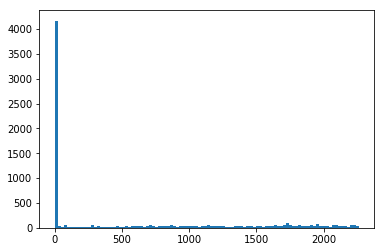

In [30]:
plt.hist(d.isna().sum(), bins = 100)

In [31]:
d = d.iloc[:, list(np.where(d.isna().sum() < 20)[0])]
d = d.fillna(method = "bfill")
d.shape

(2264, 4165)

Alright, now we have the data and for each stock we can take a look at their trend. Change the *ticker_name* below and have a look at the plot. I'm plotting the Microsoft stock prices from some day in December 2012 up to December 2019.

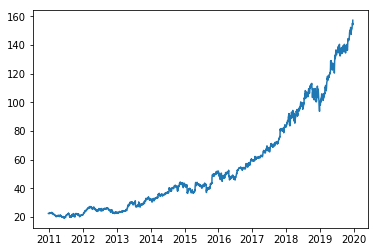

In [32]:
ticker_name = "MSFT"
import matplotlib.pyplot as plt
plt.plot(d[ticker_name])

Alright, we have the data, now it's time to model them. Here we have some choices to make. I have listed a few of them here and also explained my approach:
- First question is whether we want to model the problem as univariate or multivariate prediction. i.e. looking at each stock separately or try getting help from other stocks' data in forecasting of the price.
 *  My initial goal was to build a multivariate model. I have over 4000 stock tickers that I want to analyze. My [non-financially-trained] thinking was that these stocks are correlated one-way or another and we can use the trend in one stock to help prediction in other stock as well. This proved to be a difficult thing to do. i.e. I had worse performance when training multivariate model as opposed to univariate. I still have a filling that multivariate is the way to go*. But since I rather have shallower networks that won't take long training, I will be approahcing the problem as univariate, meaning I will loop over each company, train a model for that stock based only on that stock's data and make prediction, then move to the next company. *Another approach that I have a strong feeling about is to first cluster the companies for example based on the type of business and try multivariate forecasting for each cluster. For example we can try multivariate forecasting for fintech companies, then for construction companies, then for biotech or pharmaceutical companies. This method assumes that macroeconomic trends affect a whole set of businesses and we can better capture the variations in prices of these businesses if we look at them as a whole. I yet have to try this method.*
- Another choice -a rather technical one- is about data normalization. As a rule of thumb we know that we generally need to perform some type of data normalization. Well, here is a table I compiled based on a few small experiments. In all these experiments I have tried a shallow network with 3 to 4 layers and each layer with 128 to 512 units of the specified type. Interestingly, as you can see in this table many of the methods result in a prediction closer to the mean of the training data. Of course, **this can be most of all a result of the loss function**, as well as other factors, including network architecture, and the normalization method.

| Architecture | Normalization | Loss | Output|  
|-|-|-|-|  
| SimpleRNN-based | None  |  mae, mse, or huber | close to mean with small variance |  
| SimpleRNN-based | 0-1 scaling  |  mae, mse, or huber | close to mean with small variance |  
| LSTM-based | None  |  mae, mse, or huber | close to mean with small variance |  
| LSTM-based | 0-1 scaling  |  mae, mse, or huber | better than mean! |  
| GRU-based | None  |  mae, mse, or huber | close to mean with small variance |  
| GRU-based | 0-1 scaling  |  mae, mse, or huber | better than mean! |  

* Loss Function: MSE gives higher value to outliers, whereas MAE gives equal importance to all data points. Huber works somewhere in between the MSE and MAE, with quadratic penalty for smaller losses and linear penalty for larger losses. I don't like how MSE performs on this data, MAE and Huber are better options IMHO, but feel free to change it if you'd like.

*A NOTE ON DATA NORMALIZATION:* A silly mistake I made here and took me hours to realize and fix: We are performing a simple scaling of data to 0-1. I was excited to learn about the *Lambda* layers in keras. And I was trying to do the scaling using these layers by pre-computing the maximum of each column in the training data (in multivariate setting, or the maximum of "the column" in the univariate setting) and passing it on to the lambda layer which would run the scaling code below by dividing all entries of a column to the maximum of that column (computed from training data). Then performing the reverse on the output of the model. On the other hand, since I was performing a data scaling to 0-1, I automatically set my last layer to have a 'tanh' activation, followed by (x+1)/2 in the scaling lambda layer. Sounds fair, right?! NO - because the scaling factors are computed on the training data, and the post-modified tanh layer output is in 0-1 range, multiplying it by the normalization factor can be at most as big as the normalization factor, aka the maximum number in each column in the training data. Surprise, our prices are not limited to that range, and I certainly hope the stock will have an upward trend, exceeding the maximum in the previous values. Simple solution: do not use tanh or sigmoid or softmax on your last layer; let it roam freely! Use linear, or relu maybe? (another option is to use the maximum in the entire column rather than training data, but still that limits our output to a certain number if your output layer has for exampe tanh activation). After all, it seems like exponential and **elu** activation on the output layer (prior to scaling back) gives the best performance in this problem.

In [33]:
# this function is copied exactly from the deeplearning.ai course on time-series analysis on coursera!
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [34]:
#d = d.iloc[:, :1]#:int(d.shape[1]/2)]
d = d.loc[:,['A']]
d.describe()

,A
count,2264.000000
mean,44.591899
std,16.918005
min,18.940000
25%,30.517500
50%,39.035000
75%,61.800000
max,84.940000


In [35]:
d.reset_index(drop = False, inplace = True)

In [36]:
d['weekday'] = d['Date'].dt.day_name()
d = d[d['weekday'] == "Friday"]
print(d.shape)
print(d.head())

(456, 3)
         Date      A weekday
5  2010-12-31  27.18  Friday
10 2011-01-07  27.24  Friday
15 2011-01-14  28.07  Friday
19 2011-01-21  27.88  Friday
24 2011-01-28  27.88  Friday


In [37]:
d = d.loc[:,['A']]
d.describe()

,A
count,456.000000
mean,44.713026
std,17.060799
min,20.330000
25%,30.500000
50%,39.090000
75%,62.732500
max,84.940000


In [38]:
window_size = 30
batch_size = 32
shuffle_buffer = 100000
training_points = 350

In [39]:
#d = d / train_d.max(axis = 0)
train_d = d.iloc[:training_points, :]
valid_d = d.iloc[-training_points:, :]
train_df = windowed_dataset(train_d.to_numpy(), window_size, batch_size, shuffle_buffer)
normalization_factors = train_d.max()
valid_df = windowed_dataset(valid_d.to_numpy(), window_size, batch_size, shuffle_buffer)

In [40]:
train_d.tail()

,A
1723,66.61
1728,66.89
1733,66.16
1738,67.32
1742,67.62


In [41]:
def layer_normalize(x, factors = None, denorm = False):
    if factors is None:
        factors = tf.reduce_max(x, axis = 0, keepdims = False)
        #tf.print(factors)
        tf.print("pre mod shape of x")
        tf.print(tf.shape(x))
        tf.print("shape of factors")
        tf.print(tf.shape(factors))
    if denorm:
        #x += 1
        factors = 1. / factors
    x /= factors
    #tf.print("post mod shape of x")
    #tf.print(tf.shape(x))
    return x

In [55]:
output_size = train_d.shape[1]
#output_size = 1
print(output_size)
inner_layers = tf.keras.models.Sequential([
  #tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]), #if the input is one stock
  tf.keras.layers.Lambda(layer_normalize, arguments={'factors': normalization_factors, 'denorm' : False}),
  #tf.keras.layers.Conv1D(128, kernel_size = 3, input_shape = (batch_size, window_size, None)),
  #tf.keras.layers.AveragePooling1D(),
  #tf.keras.layers.Conv1D(256, kernel_size = 3),
  #tf.keras.layers.AveragePooling1D(),
  #tf.keras.layers.Conv1D(256, kernel_size = 1),
  #tf.keras.layers.AveragePooling1D(),
  #tf.keras.layers.Conv1D(256, kernel_size = 1, activation = 'relu'),
  #tf.keras.layers.AveragePooling1D(),
  #tf.keras.layers.GRU(512, return_sequences=True),
  #tf.keras.layers.Dropout(0.5),
  #tf.keras.layers.GRU(256, return_sequences=True),
  #tf.keras.layers.GRU(256, return_sequences=True),
  #tf.keras.layers.GRU(256, return_sequences=True),
  #tf.keras.layers.GRU(256),
  #tf.keras.layers.SimpleRNN(128, return_sequences=True),
  #tf.keras.layers.SimpleRNN(256, return_sequences=True),
  #tf.keras.layers.SimpleRNN(512, return_sequences=True),
  #tf.keras.layers.SimpleRNN(256, return_sequences=True),
  #tf.keras.layers.SimpleRNN(128),
  tf.keras.layers.LSTM(128, return_sequences=True),
  tf.keras.layers.LSTM(256, return_sequences=True),
  #tf.keras.layers.Dropout(0.5),
  tf.keras.layers.LSTM(256, return_sequences=True),
  tf.keras.layers.LSTM(128),
  #tf.keras.layers.Dropout(0.5),
  #tf.keras.layers.LSTM(256, return_sequences=True),
  #tf.keras.layers.Dropout(0.5),
  #tf.keras.layers.LSTM(256, return_sequences=True, activation = 'relu'),
  #tf.keras.layers.Dropout(0.5),
  #tf.keras.layers.LSTM(256, return_sequences=True, activation = 'relu'),
  #tf.keras.layers.Dropout(0.5),
  #tf.keras.layers.LSTM(256, return_sequences=True, activation = 'relu'),
  #tf.keras.layers.Dropout(0.5),
  #tf.keras.layers.LSTM(256, return_sequences=True, activation = 'relu'),
  #tf.keras.layers.LSTM(256, return_sequences=True, activation = 'relu'),
  #tf.keras.layers.LSTM(256, return_sequences=True, activation = 'relu'),
  #tf.keras.layers.Dropout(0.5),
  #tf.keras.layers.LSTM(256, return_sequences=True, activation = 'relu'),
  #tf.keras.layers.LSTM(256, return_sequences=True, activation = 'relu'),
  #tf.keras.layers.LSTM(256, activation = 'tanh', return_sequences=True),
  #tf.keras.layers.LSTM(128),
  #tf.keras.layers.SimpleRNN(64, return_sequences = True),
  #tf.keras.layers.SimpleRNN(128, return_sequences = True),
  #tf.keras.layers.SimpleRNN(256),
#  tf.keras.layers.Dense(output_size, activation = 'elu'),
  #tf.keras.layers.Lambda(lambda x: x + 1),
#  tf.keras.layers.Lambda(layer_normalize, arguments={'factors': normalization_factors, 'denorm' : True})
])

sigmoid_out = tf.keras.layers.Dense(units=1, activation=tf.nn.sigmoid)
relu_out = tf.keras.layers.Dense(units=1, activation=tf.nn.relu)
out = tf.concat([sigmoid_out, relu_out], axis=1)
inner_layers.add(out)

denorm_layer = tf.keras.layers.Lambda(layer_normalize, arguments={'factors': normalization_factors, 'denorm' : True})

inner_layers.add(denorm_layer)
model = inner_layers

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-2 * 10**(epoch / 20))
#optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
#optimizer = tf.keras.optimizers.SGD(lr=1e-7, momentum=0.9)
#optimizer = tf.keras.optimizers.SGD(lr=1e-10, momentum = 0.9, clipnorm = 2)
optimizer = tf.keras.optimizers.Adam()
#optimizer = tf.keras.optimizers.RMSprop()
model.compile(loss=tf.keras.losses.Huber(),
              #loss = 'mse',
              optimizer=optimizer,
              #optimizer = 'Adam',
              metrics = ['mae']
             )
#model.build(input_shape = (batch_size, window_size, None))
#model.summary()
#history = model.fit(df, epochs=2, callbacks = [lr_schedule])
history = model.fit(train_df, epochs=10, validation_data = valid_df)#, callbacks = [lr_schedule])

1


ValueError: Attempt to convert a value (<tensorflow.python.keras.layers.core.Dense object at 0x137d42898>) with an unsupported type (<class 'tensorflow.python.keras.layers.core.Dense'>) to a Tensor.

In [47]:
d.to_numpy()[50:55, :8]
train_d.describe()

,A
count,350.000000
mean,36.926943
std,10.391520
min,20.330000
25%,28.770000
50%,36.630000
75%,40.460000
max,67.620000


In [48]:
#p = model.predict(np.array(d['MSFT']).reshape((len(d['MSFT']), 1)))
p = model.predict(train_df)
#p = p.reshape((1480, 4165))
print(d.shape)
print(p.shape)
p = pd.DataFrame(p)
p2 = p #* d.max(axis = 0).reset_index(drop = True)
p2.describe()

(456, 1)
(320, 1)


,0
count,320.000000
mean,37.138153
std,10.294842
min,22.992464
25%,28.061047
50%,37.789833
75%,40.328719
max,68.559135


In [49]:
p = model.predict(valid_df)
#p = p.reshape((1480, 4165))
print(d.shape)
print(p.shape)
p = pd.DataFrame(p) #* d.max(axis = 0).reset_index(drop = True)
print(p.describe())

(456, 1)
(320, 1)
                0
count  320.000000
mean    53.647156
std     17.604563
min     29.650517
25%     38.942946
50%     45.921932
75%     72.340284
max     86.852776


In [ ]:
print(valid_d.describe())
print(train_d.describe())

In [ ]:
valid_d.tail()

In [ ]:
p2 = model.predict(df)
pd.DataFrame(p2).describe()

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-1, 130000, 170000])

In [ ]:
np.where(d.columns.values == "MSFT")

In [ ]:
p[:, 2572].max()

In [ ]:
t.tickers[0].info

In [ ]:
t = yf.Tickers(' '.join(list(tickers.keys())))

In [ ]:
#df = t.history(period="9y", interval = '1d')
?Tickers.history

In [ ]:
yf.Tickers.history

In [ ]:
t.history(period="9y", interval = '1d', 'Open')